In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from fastprogress.fastprogress import progress_bar
import time

import catboost
from catboost import CatBoostClassifier

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.viz import plot_uplift_preds, plot_qini_curve
from sklift.metrics.metrics import qini_auc_score

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold


from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier

In [ ]:
#!pip install --upgrade nbformat

In [2]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
RANDOM_SEED = 42
#INPUT_DIR_PATH = 'gdrive/My Drive/Colab Notebooks/Uplift modeling/Megafon_competition/' #For Google Collabratory
INPUT_DIR_PATH = ''

In [3]:
train = pd.read_csv(INPUT_DIR_PATH+'data/train.csv')
train.sample(5)

id treatment_group         X_1       X_2        X_3        X_4  \
598367  598367         control   32.798433 -0.635783  -5.146319  69.858027   
418227  418227         control  112.602748  1.129621  -4.290585  29.394719   
575662  575662         control   56.199971  0.568469 -54.372473 -51.202962   
409092  409092         control   27.930504  0.247231  10.494154  70.569114   
536491  536491       treatment   66.317298 -1.163562   0.312406 -39.769376   

              X_5         X_6         X_7         X_8  ...        X_42  \
598367 -62.768077  166.494095  -39.865919  -60.701713  ...  208.958513   
418227 -67.517350 -238.445168 -104.294116   45.386690  ... -108.684506   
575662 -32.066903  -52.761219  -76.592235   45.399840  ...  -99.662273   
409092  76.917211  211.857258    9.781466  110.340933  ...  158.094646   
536491 -23.196384  -67.174531  -60.714950   24.724398  ... -273.881612   

              X_43      X_44       X_45      X_46        X_47        X_48  \
598367  -29.468067  1.976104 -61.293503 -0.504520 -510.634203 -188.166456   
418227 -116.214065  0.055580 -13.063349 -1.400489 -432.930305  -71.582918   
575662  215.883156  2.090774  61.047260  0.561354   49.449893   35.477523   
409092   -4.412749 -1.553233  44.838888 -0.052673  319.976008    1.756304   
536491   25.044204 -0.258557 -22.795720 -0.161093 -435.943428   33.695205   

              X_49       X_50  conversion  
598367 -165.081304  19.703113           1  
418227  140.104469 -38.508878           0  
575662   63.976572  -9.774974           0  
409092 -110.278489  14.603114           0  
536491  259.112954   2.927501           0  

[5 rows x 53 columns]

In [4]:
test = pd.read_csv(INPUT_DIR_PATH+'data/test.csv')
test.sample(5)

id treatment_group         X_1       X_2        X_3        X_4  \
117081  117081         control  -54.298063 -2.024476  33.465637   3.661985   
375759  375759       treatment    8.732867 -0.707382 -43.438208  18.008724   
51434    51434         control  -58.165352  1.449789  28.125438 -89.176785   
755611  755611       treatment  -30.066755  1.643794  -0.223126  53.999819   
627113  627113       treatment -106.472724  0.852899  23.111460  -3.073357   

               X_5         X_6         X_7        X_8  ...        X_41  \
117081  -10.741266 -177.622250   -6.103379  38.781675  ...   94.088524   
375759    4.460779   28.620481  -22.111940 -20.489551  ...    4.642032   
51434   114.870174    5.893961   91.244661  16.650902  ...   58.494500   
755611   26.477041   -8.663928  -33.546728 -22.259456  ...  -31.069895   
627113  -11.566363  266.119572  127.982738 -70.499285  ...  338.225758   

              X_42        X_43      X_44        X_45      X_46        X_47  \
117081 -132.795167  200.997526 -0.551685   55.212365 -0.321984    4.912388   
375759  -29.210321  124.432194 -0.641085  121.315405 -0.864804  715.569510   
51434  -111.606961  353.200512  0.107326  -71.874305  1.630217 -206.863523   
755611   51.289999 -557.626316  3.564824   -2.194238  1.733629 -247.187583   
627113  220.761431 -236.950709  0.777447   68.125394  1.824959  583.184576   

              X_48        X_49       X_50  
117081  -74.666406  144.568880  28.648516  
375759  -10.870014   45.996617  -6.018626  
51434  -175.749078   45.371592  19.909157  
755611  153.519681  -10.108331 -27.386556  
627113  232.972615 -237.846740  27.415120  

[5 rows x 52 columns]

# EDA

In [ ]:
X_cols = ['X_'+str(i) for i in range(1, 51)]

In [ ]:
train[X_cols].describe()

X_1            X_2            X_3            X_4  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean       -3.758503       0.000405       0.356208      -1.004378   
std        54.881882       0.999419      31.804123      45.291429   
min      -271.659497      -4.372119    -148.870768    -244.446728   
25%       -40.693313      -0.673108     -20.758308     -30.644608   
50%        -3.954771       0.000915       0.372583      -0.585368   
75%        33.174835       0.673056      21.495530      29.027860   
max       250.812280       5.062006     170.053291     235.095937   

                 X_5            X_6            X_7            X_8  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        3.376919      -6.396371      -2.253712      -6.432606   
std        53.397644     140.873734      59.810396      74.840857   
min      -302.574049    -683.126343    -322.731683    -506.202937   
25%       -31.865404    -100.762161     -42.313674     -54.840796   
50%         3.720738      -6.357443      -2.263690      -6.416419   
75%        38.988940      88.159514      37.709780      41.962767   
max       284.915947     656.482242     293.909622     550.525780   

                 X_9           X_10  ...           X_41           X_42  \
count  600000.000000  600000.000000  ...  600000.000000  600000.000000   
mean       -0.061507      -1.659301  ...       6.882868      -6.632834   
std        44.912292     199.625148  ...     163.776538     137.025868   
min      -218.466369    -920.347783  ...    -810.842593    -633.575178   
25%       -30.327330    -134.565241  ...    -102.658380     -99.033996   
50%        -0.103742      -1.628897  ...       7.190600      -6.784760   
75%        30.144501     130.948487  ...     116.755600      85.621324   
max       219.628423    1251.776972  ...     867.086690     689.626208   

                X_43           X_44           X_45           X_46  \
count  600000.000000  600000.000000  600000.000000  600000.000000   
mean        8.454493       0.001296       0.007967      -0.000966   
std       262.840194       1.000368      71.553713       0.999902   
min     -1345.838757      -4.756720    -360.713742      -4.516004   
25%      -167.634846      -0.673780     -48.250836      -0.675549   
50%         8.773280       0.001639       0.045537      -0.002251   
75%       185.382370       0.675779      48.221733       0.673638   
max      1488.759454       4.727996     384.665348       5.086304   

                X_47           X_48           X_49           X_50  
count  600000.000000  600000.000000  600000.000000  600000.000000  
mean      -22.259600      -5.759041       6.241130      -1.176456  
std       500.900364     130.952113     141.211999      21.363662  
min     -2506.960013    -687.526201    -702.184241     -98.094323  
25%      -357.547278     -93.163915     -88.803657     -15.580688  
50%       -20.695017      -5.774627       6.286783      -1.199895  
75%       313.295748      81.636824     101.558007      13.230410  
max      2534.503855     595.321844     630.727101     112.233293  

[8 rows x 50 columns]

In [ ]:
test[X_cols].describe()

X_1            X_2            X_3            X_4  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean       -3.722133       0.001565       0.292386      -0.918856   
std        54.883480       0.999328      31.822634      45.333520   
min      -265.826804      -5.058454    -154.824993    -233.427703   
25%       -40.640901      -0.672790     -20.798191     -30.486239   
50%        -3.713427       0.000676       0.330985      -0.455754   
75%        33.194777       0.674678      21.379638      29.080698   
max       266.378566       5.000025     162.633031     217.847171   

                 X_5            X_6            X_7            X_8  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean        3.384986      -6.095182      -2.189463      -6.330064   
std        53.355458     141.016399      59.814484      74.723545   
min      -310.846748    -675.818437    -340.570902    -486.515465   
25%       -31.794548    -100.194378     -42.243541     -54.736079   
50%         3.613102      -5.968265      -2.225678      -6.351923   
75%        38.919897      88.149642      37.868263      42.087660   
max       299.107131     771.727707     322.600255     523.821776   

                 X_9           X_10  ...           X_41           X_42  \
count  900000.000000  900000.000000  ...  900000.000000  900000.000000   
mean        0.027311      -2.372028  ...       6.600405      -6.516465   
std        44.914866     199.764560  ...     163.775316     136.963572   
min      -231.862968    -992.562019  ...    -867.031085    -713.381445   
25%       -30.215361    -135.064011  ...    -102.565898     -98.793036   
50%         0.061359      -2.239605  ...       6.919118      -6.617453   
75%        30.297931     130.406870  ...     116.233203      85.582126   
max       211.009639     967.448724  ...     852.811713     751.876198   

                X_43           X_44           X_45           X_46  \
count  900000.000000  900000.000000  900000.000000  900000.000000   
mean        8.549592       0.001630       0.097868      -0.000802   
std       262.253197       0.999040      71.570123       0.999343   
min     -1305.958512      -4.592248    -365.762558      -4.685599   
25%      -166.857295      -0.672094     -48.195706      -0.676214   
50%         8.837780       0.001374       0.079309      -0.002408   
75%       184.923011       0.675779      48.358023       0.674383   
max      1390.007161       5.189388     334.912902       4.388608   

                X_47           X_48           X_49           X_50  
count  900000.000000  900000.000000  900000.000000  900000.000000  
mean      -22.823396      -5.990471       6.187666      -1.137033  
std       500.947935     130.984426     141.119171      21.325592  
min     -2434.560042    -640.581265    -763.087609    -106.120143  
25%      -358.109023     -93.649749     -88.621928     -15.532971  
50%       -22.598330      -5.867984       6.303570      -1.136908  
75%       313.242725      81.400333     101.334352      13.226274  
max      2505.079391     688.542045     704.178967      94.514053  

[8 rows x 50 columns]

## Treatment distribution

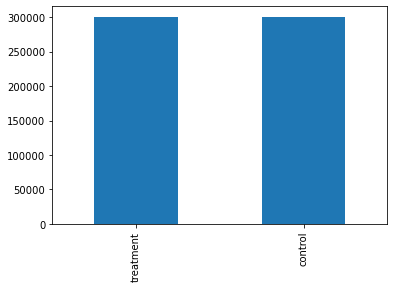

In [ ]:
train['treatment_group'].value_counts().plot(kind='bar');

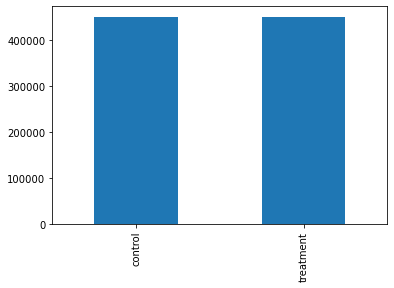

In [ ]:
test['treatment_group'].value_counts().plot(kind='bar');

## Conversion

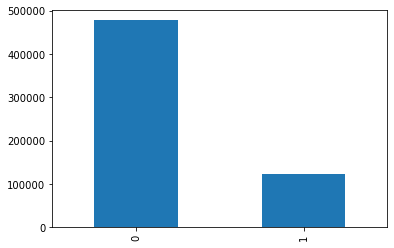

In [ ]:
train['conversion'].value_counts().plot(kind='bar');

In [ ]:
def create_n_x_columns_list(n=10):
    return ['X_' + str(x) for x in np.random.randint(1, 50, n)]

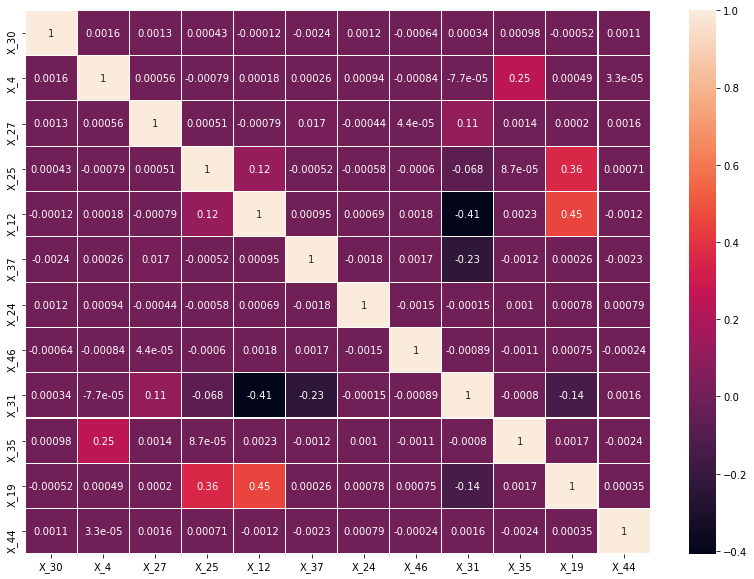

In [ ]:
fig = plt.figure(figsize=(14, 10))
sns.heatmap(train[create_n_x_columns_list(12)].corr(), annot=True, linewidths=0.1);

In [ ]:
train[X_cols].corr()

X_1       X_2       X_3       X_4       X_5       X_6       X_7  \
X_1   1.000000  0.000237  0.000298 -0.001226 -0.049792 -0.000530 -0.561628   
X_2   0.000237  1.000000  0.001216 -0.000496 -0.000288  0.000127 -0.000556   
X_3   0.000298  0.001216  1.000000  0.001607 -0.001747  0.050732  0.029499   
X_4  -0.001226 -0.000496  0.001607  1.000000  0.000278 -0.000016  0.001212   
X_5  -0.049792 -0.000288 -0.001747  0.000278  1.000000  0.000565  0.033742   
X_6  -0.000530  0.000127  0.050732 -0.000016  0.000565  1.000000  0.337474   
X_7  -0.561628 -0.000556  0.029499  0.001212  0.033742  0.337474  1.000000   
X_8   0.204052 -0.000378 -0.000503  0.000522  0.494332 -0.000368 -0.138795   
X_9   0.001024 -0.001035 -0.000159 -0.001214 -0.000661 -0.000419 -0.001461   
X_10 -0.001349 -0.001094 -0.098318  0.000181  0.000460 -0.212909 -0.094648   
X_11  0.001524  0.001385  0.092319 -0.011217 -0.000903 -0.038439  0.003819   
X_12 -0.001349 -0.001094 -0.098318  0.000181  0.000460 -0.212909 -0.094648   
X_13  0.000347 -0.001077 -0.001015 -0.001449  0.000854 -0.001179 -0.003126   
X_14  0.000997 -0.000237  0.048025 -0.228990  0.001066  0.077927  0.109653   
X_15  0.000313  0.000493 -0.037551  0.058002  0.001039 -0.425511 -0.779780   
X_16  0.001455  0.000399  0.000260  0.454651 -0.001341  0.001280 -0.001131   
X_17  0.000935  0.001219  0.318734  0.000401 -0.000484  0.060037 -0.205080   
X_18 -0.000083 -0.000474 -0.001422 -0.000751  0.001635  0.001415  0.001997   
X_19  0.001852  0.000687 -0.124040  0.000491  0.000305 -0.202739 -0.282273   
X_20 -0.497299 -0.000242  0.000077  0.001172  0.028105 -0.000191  0.066354   
X_21  0.000073  0.000514 -0.037837 -0.000788  0.001061 -0.428768 -0.786318   
X_22 -0.430820 -0.000453 -0.002862  0.000171  0.810120  0.001177  0.292840   
X_23  0.001020 -0.000198  0.000763 -0.000779 -0.000727 -0.000911 -0.000303   
X_24 -0.001844  0.001957 -0.000785  0.000940 -0.000758  0.000327  0.001614   
X_25  0.000073  0.000514 -0.037837 -0.000788  0.001061 -0.428768 -0.786318   
X_26  0.000539 -0.000054  0.001887  0.001487  0.001306  0.000717  0.000046   
X_27 -0.111724  0.000072  0.002679  0.000558  0.320374  0.001207  0.075570   
X_28  0.002369 -0.000970 -0.136298 -0.001203  0.000522 -0.091525  0.054518   
X_29  0.001887  0.000039 -0.001445 -0.249049  0.001293 -0.002979 -0.002889   
X_30  0.001618 -0.001096  0.001104  0.001596  0.000326 -0.000124 -0.001366   
X_31 -0.170735  0.001187  0.263322 -0.000077 -0.416281  0.003703  0.169059   
X_32 -0.001099  0.000208  0.187878  0.000510  0.001059  0.408459 -0.344564   
X_33 -0.000771  0.000674  0.305897  0.001036 -0.002203  0.173996  0.469020   
X_34  0.000172 -0.001861  0.001768  0.001151 -0.001684  0.000894  0.000877   
X_35  0.000265 -0.000736 -0.001667  0.250213  0.001017 -0.003978 -0.000738   
X_36 -0.908952 -0.000247 -0.000412  0.000959  0.055965  0.000488  0.617749   
X_37  0.054631 -0.000640  0.001502  0.000255  0.136383  0.000703 -0.035996   
X_38  0.001601  0.001607  0.486182  0.000670 -0.001044  0.006277  0.096788   
X_39  0.000048 -0.000316 -0.182073  0.001322 -0.000646 -0.126191  0.148876   
X_40  0.001853 -0.000128 -0.000297  0.451458 -0.000104 -0.003220 -0.001575   
X_41 -0.001118  0.000128  0.750596  0.001795 -0.000525  0.317384  0.164871   
X_42 -0.002482  0.000386 -0.232548  0.255415  0.000339  0.360009  0.176614   
X_43  0.002369 -0.000970 -0.136298 -0.001203  0.000522 -0.091525  0.054518   
X_44  0.000844  0.000954  0.001517  0.000033 -0.000410  0.000210 -0.001098   
X_45 -0.417863 -0.000031  0.000185  0.000852 -0.002526  0.000209  0.000953   
X_46 -0.001307 -0.000108 -0.001174 -0.000840 -0.001024 -0.001086  0.001210   
X_47 -0.001536 -0.001357 -0.092334  0.001241  0.000863  0.038632 -0.003793   
X_48 -0.002702 -0.001605  0.128031  0.000784  0.000105  0.101432 -0.073265   
X_49  0.002243 -0.000531  0.240952  0.000500 -0.000277 -0.372364 -0.182352   
X_50 -0.342196 -0.000754 -0.000355  0.001257  0.108391 -0.001390  0.232340   

           X_8       X_9      X_

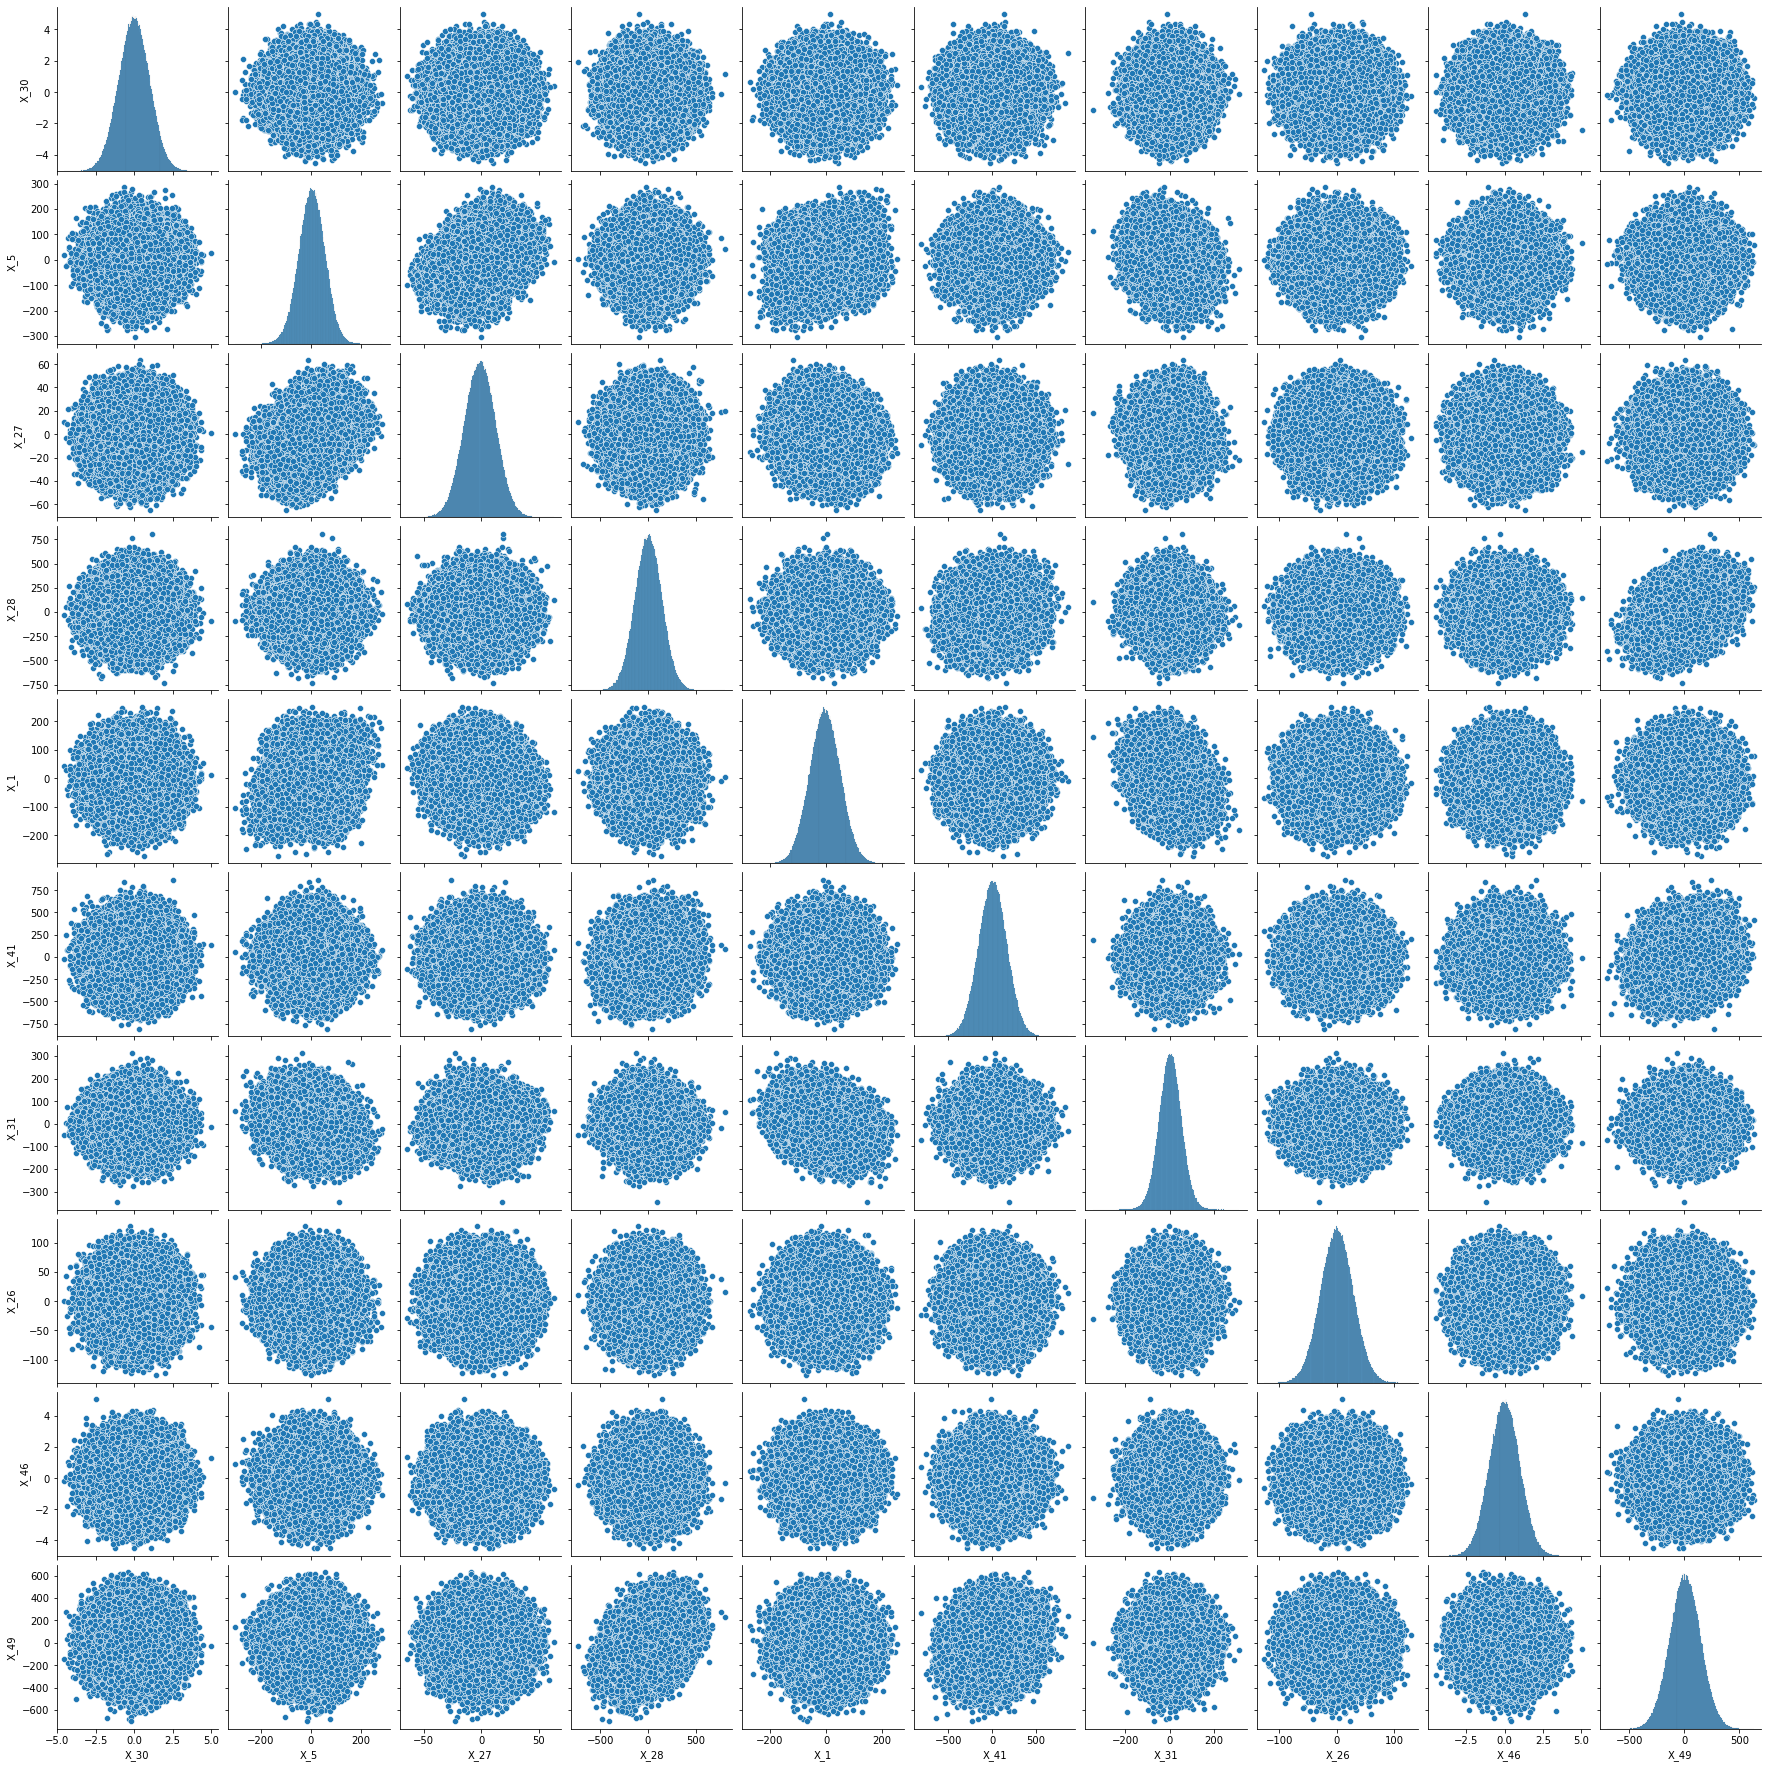

In [ ]:
sns.pairplot(train[create_n_x_columns_list()]);

# Preprocessing

In [5]:
X = train.drop(['id', 'conversion'], axis=1)
X['treatment_group'] = X['treatment_group'].map({'treatment':1, 'control':0})
y = train['conversion'].copy()
treatment = X['treatment_group'].copy()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

treatment_train = X_train['treatment_group'].copy()
treatment_val = X_val['treatment_group'].copy()

X_train.drop(['treatment_group'], inplace=True, axis=1)
X_val.drop(['treatment_group'], inplace=True, axis=1)

X_test = test.drop(['id', 'treatment_group'], axis=1) # Не факт, чтр нужно удалять флаг воздействия

X.drop(['treatment_group'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Solo Model (S-learner)

In [ ]:
%%time

model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
solo_model = SoloModel(model)
solo_model.fit(X_train, y_train, treatment_train, estimator_fit_params={'plot': True})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2min 51s


SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001D18175F688>,
          method='dummy')

In [ ]:
pred = solo_model.predict(X_val)
print('qini score', qini_auc_score(y_val, pred, treatment_val))

qini score 0.24014821124049487


In [ ]:
model = CatBoostClassifier(verbose=0, random_seed=RANDOM_SEED)
solo_model = SoloModel(model)
solo_model.fit(X, y, treatment)

SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x000001D180198888>,
          method='dummy')

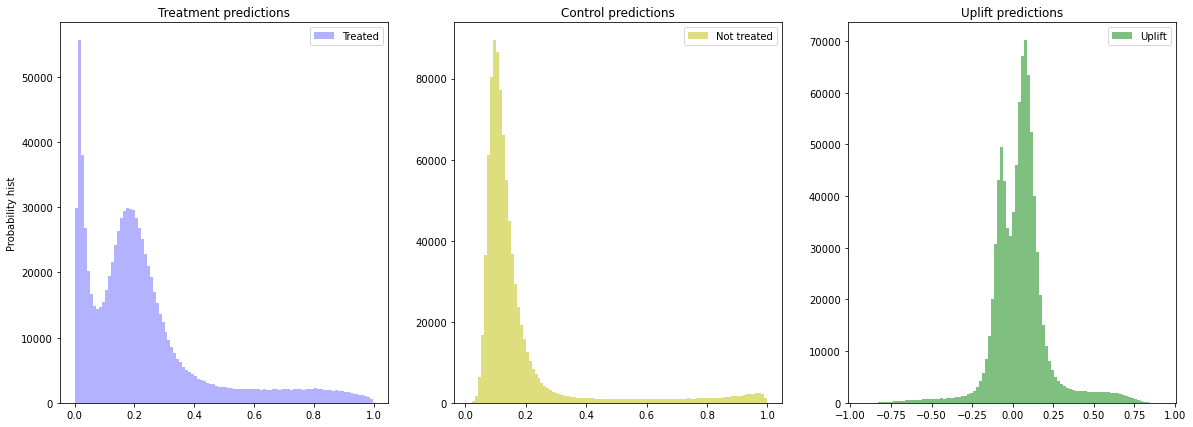

In [ ]:
treatment_preds = solo_model.trmnt_preds_
control_preds = solo_model.ctrl_preds_

plot_uplift_preds(treatment_preds, control_preds);

# Two models (T-learner)

In [8]:
treatment_model = CatBoostClassifier(silent=True)
control_model = CatBoostClassifier(silent=True)

two_models = TwoModels(treatment_model, control_model)
two_models.fit(X_train, y_train, treatment_train)

In [8]:
preds = two_models.predict(X_val)
print('qini scores:', qini_auc_scoreauc_score(y_val, preds, treatment_val))

qini scores: 0.24104986490202612


## PCA

In [12]:
qini_scores_train = []
qini_scores_val = []

for n_comp in  progress_bar(range(10, 50, 10)): 
    treatment_model = CatBoostClassifier(silent=True, random_seed=RANDOM_SEED)
    control_model = CatBoostClassifier(silent=True, random_seed=RANDOM_SEED)
    two_models = TwoModels(treatment_model, control_model)

    pca_transformer = PCA(n_components=n_comp)
    X_train_pca = pca_transformer.fit_transform(X_train)
    X_val_pca = pca_transformer.transform(X_val)

    two_models.fit(X_train_pca, treatment_train, y_train)
    qini_scores_train.append(qini_auc_score(y_train, two_models.predict(X_train_pca), treatment_train))
    qini_scores_val.append(qini_auc_score(y_val, two_models.predict(X_val_pca), treatment_val))

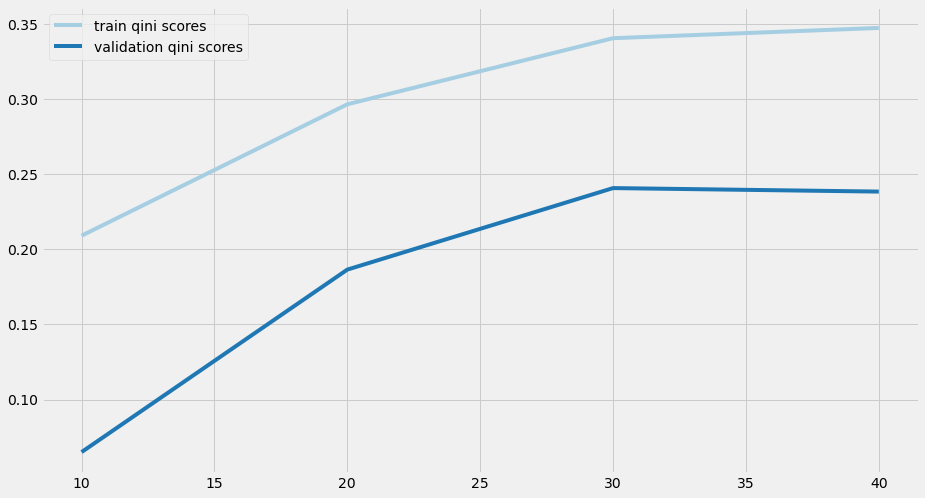

In [15]:
fig = plt.figure(figsize=(14, 8))
plt.plot(np.arange(10, 50, 10), qini_scores_train, label='train qini scores')
plt.plot(np.arange(10, 50, 10), qini_scores_val, label='validation qini scores')
plt.legend()
plt.show()

In [17]:
max(qini_scores_val)

0.24073655698747085

# Two depends models(X-learner)

## ddr_control

In [ ]:
control_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)
treatment_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)

two_depends_models = TwoModels(treatment_model, control_model, method='ddr_control')
two_depends_models.fit(X_train, y_train, treatment_train)

TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x000001D1A0F7E488>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x000001D1A161E748>,
          method='ddr_control')

In [ ]:
pred = two_depends_models.predict(X_val)
print('qini score:', qini_auc_score(y_val, pred, treatment_val))

qini score: 0.2336718328799594


In [ ]:
two_depends_models = TwoModels(treatment_model, control_model, method='ddr_control')
two_depends_models.fit(X, y, treatment)

TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x000001D1A0F7E488>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x000001D1A161E748>,
          method='ddr_control')

## ddr_treatment

In [ ]:
control_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)
treatment_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)

two_depends_models = TwoModels(treatment_model, control_model, method='ddr_treatment')
two_depends_models.fit(X_train, y_train, treatment_train)

TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x000001D1A1693C48>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x000001D1A1693B08>,
          method='ddr_treatment')

In [ ]:
pred = two_depends_models.predict(X_val)
print('qini score:', qini_auc_score(y_val, pred, treatment_val))

qini score: 0.24000910789724617


In [ ]:
control_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)
treatment_model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)

two_depends_models = TwoModels(treatment_model, control_model, method='ddr_treatment')
two_depends_models.fit(X, y, treatment)

TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x000001D184AEBE08>,
          estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x000001D184AEB208>,
          method='ddr_treatment')

## Class Transformation

In [ ]:
model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)
class_transformation_model = ClassTransformation(model)

class_transformation_model.fit(X_train, y_train, treatment_train)

C:\Users\ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000001D18142AF88>)

In [ ]:
pred = class_transformation_model.predict(X_val)
print('qini score:', qini_auc_score(y_val, pred, treatment_val))

qini score: 0.2202263091786293


In [ ]:
model = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0)
class_transformation_model = ClassTransformation(model)

class_transformation_model.fit(X, y, treatment)

C:\Users\ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x000001D1A17EE748>)

# Uplift trees

In [11]:
X = train.drop(['id', 'conversion'], axis=1)
y = train['conversion'].copy()
treatment = X['treatment_group'].copy()

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

treatment_train = X_train['treatment_group'].copy()
treatment_val = X_val['treatment_group'].copy()

X_train.drop(['treatment_group'], inplace=True, axis=1)
X_val.drop(['treatment_group'], inplace=True, axis=1)

X_test = test.drop(['id', 'treatment_group'], axis=1) # Не факт, чтр нужно удалять флаг воздействия

X.drop(['treatment_group'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
uplift_model = UpliftTreeClassifier(control_name='control')

uplift_model.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

In [13]:
def binarize_treatment_group(group):
    if group == 'treatment':
        return 1
    else:
        return 0

In [ ]:
pred = list(map(binarize_treatment_group, uplift_model.predict(X_val.values)[0]))
print('qini score:', qini_auc_score(y_val, pred, treatment_val.map({'treatment':1, 'control':0})))

qini score: 0.04034134436562256


In [ ]:
treatment_val

4242        control
60608       control
392832      control
41643       control
464234      control
            ...    
80168     treatment
204073      control
328962      control
91500     treatment
245798    treatment
Name: treatment_group, Length: 180000, dtype: object

In [ ]:
%%time
uplift_model = UpliftRandomForestClassifier(control_name='control', max_features=8, n_estimators=20, max_depth=6)

uplift_model.fit(X_train.values, treatment=treatment_train.values, y=y_train.values)

Wall time: 9min 28s


In [ ]:
pred = uplift_model.predict(X_val.values)[:, 0]
print('qini score:', qini_auc_score(y_val, pred, treatment_val.map({'treatment':1, 'control':0})))

qini score: 0.13349431315482252


In [ ]:
?UpliftRandomForestClassifier

# Grid Search for Uplift Random Forest Classifier

In [ ]:
params = {
    'max_features':np.arange(6, 9)
    'n_estimators':np.arange(10)
}

In [15]:
kf_splits = KFold(n_splits=2)

for train_indexes, test_indexes in kf_splits.split(X):
    print(train_indexes)

[300000 300001 300002 ... 599997 599998 599999]
[     0      1      2 ... 299997 299998 299999]


In [ ]:
#UpliftRandomForestClassifier(control_name='control').fit(X.values, treatment.values, y.values)

# Predictions

## Sub1

In [ ]:
prediction = solo_model.predict(X_test)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

id      pred
0   0 -0.174851
1   1 -0.716616
2   2 -0.447910
3   3 -0.666618
4   4 -0.965171

In [ ]:
sub = pd.DataFrame()
sub['id'] = test['id'].copy()
sub['pred'] = prediction
sub.to_csv('submissions/sub1.csv', index=False)

## Sub2

In [ ]:
prediction = two_models.predict(X_test)
sub = pd.DataFrame()
sub['id'] = test['id'].copy()
sub['pred'] = prediction
sub.to_csv('submissions/sub2.csv', index=False)

## Sub3

In [9]:
def create_prediction_df(preds):
    sub = pd.DataFrame()
    sub['id'] = test['id'].copy()
    sub['pred'] = preds
    return sub

In [ ]:
sub = create_prediction_df(two_depends_models.predict(X_test))
sub.to_csv('submissions/sub3.csv', index=False)

## Sub4

Two_depends models, ddr_treatment

In [ ]:
sub = create_prediction_df(two_depends_models.predict(X_test))
sub.to_csv('submissions/sub4.csv', index=False)

## Sub5

In [ ]:
sub = create_prediction_df(class_transformation_model.predict(X_test))
sub.to_csv('submissions/sub5.csv', index=False)

In [16]:
len(X_test)

900000

## Sub6

In [ ]:
X_test = poly_transformer.transform(X_test)
#sub = create_prediction_df(two_models.predict(X_test))
#sub.to_csv('submissions/sub6.csv', index=False)